## Objective: 
- You work at a startup that sells food products. You need to investigate user behavior for the company's app.
- First study the sales funnel. Find out how users reach the purchase stage. How many users actually make it to this stage? How many get stuck at previous stages? Which stages in particular?

## Description of the data
Each log entry is a user action or an event.
- EventName — event name
- DeviceIDHash — unique user identifier
- EventTimestamp — event time
- ExpId — experiment number: 
    - __246 & 247 = CONTROL groups__ 
    - __248 = TEST group__

## Step 2. Prepare the data for analysis
- Rename the columns in a way that's convenient for you.
- Check for missing values and data types. Correct the data if needed
- Add a date and time column and a separate column for dates

## Step 3. Study and check the data
- How many events are in the logs?
- How many users are in the logs?
- What's the average number of events per user?
- What period of time does the data cover? Find the maximum and the minimum date. Plot a histogram by date and time. Can you be sure that you have equally complete data for the entire period? Older events could end up in some users' logs for technical reasons, and this could skew the overall picture. Find the moment at which the data starts to be complete and ignore the earlier section. What period does the data actually represent?
- Did you lose many events and users when excluding the older data?
- Make sure you have users from all three experimental groups.

## Step 4. Study the event funnel
- See what events are in the logs and their frequency of occurrence. Sort them by frequency.
- Find the number of users who performed each of these actions. Sort the events by the number of users. Calculate the proportion of users who performed the action at least once.
- In what order do you think the actions took place. Are all of them part of a single sequence? You don't need to take them into account when calculating the funnel.
- Use the event funnel to find the share of users that proceed from each stage to the next. (For instance, for the sequence of events A → B → C, calculate the ratio of users at stage B to the number of users at stage A and the ratio of users at stage C to the number at stage B.)
- At what stage do you lose the most users?
- What share of users make the entire journey from their first event to payment?

## Step 5. Study the results of the experiment
- How many users are there in each group?
- We have two control groups in the A/A test, where we check our mechanisms and calculations. See if there is a statistically significant difference between samples 246 and 247.
- Select the most popular event. In each of the control groups, find the number of users who performed this action. Find their share. Check whether the difference between the groups is statistically significant. Repeat the procedure for all other events (it will save time if you create a special function for this test). Can you confirm that the groups were split properly?
- Do the same thing for the group with altered fonts. Compare the results with those of each of the control groups for each event in isolation. Compare the results with the combined results for the control groups. What conclusions can you draw from the experiment?
- What significance level have you set to test the statistical hypotheses mentioned above? Calculate how many statistical hypothesis tests you carried out. With a statistical significance level of 0.1, one in 10 results could be false. What should the significance level be? If you want to change it, run through the previous steps again and check your conclusions.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from datetime import datetime
import seaborn as sns
#sns.set()
data = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp_us.csv', sep='\t')
                   
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


### Step 2

In [3]:
#data['EventTimestamp'] = pd.to_datetime(data['EventTimestamp'], '%c')
data

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


epoch = data[data['EventTimestamp']]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
data.isnull().sum()

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

In [6]:
data.duplicated().sum()


#413/244126 = less than %.01 of the dataframe so dropping rows

413

In [7]:
data.drop_duplicates(inplace=True)
display(data)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [8]:
data['EventTimestamp'].duplicated().sum()

67059

In [9]:
# changing date 
data['date_time'] = data['EventTimestamp'].apply(lambda x: pd.datetime.fromtimestamp(x))
data
#date column
data['date'] = data['date_time'].dt.date
data
#time column
data['time'] = data['date_time'].dt.time
data

C:\Users\akantarevic\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


,EventName,DeviceIDHash,EventTimestamp,ExpId,date_time,date,time
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-24 22:43:36,2019-07-24,22:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 05:11:42,2019-07-25,05:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 05:28:47,2019-07-25,05:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 05:28:47,2019-07-25,05:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 05:48:42,2019-07-25,05:48:42
...,...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 15:12:25,2019-08-07,15:12:25
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 15:13:59,2019-08-07,15:13:59
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 15:14:43,2019-08-07,15:14:43
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 15:14:58,2019-08-07,15:14:58


In [10]:
data['date'].max() 

datetime.date(2019, 8, 7)

In [11]:
data['date'].min() 

datetime.date(2019, 7, 24)

data['EventTimestamp'] = pd.to_datetime(data['EventTimestamp'], format='%Y%m%d%H%M%S', unit='ms')
data

In [12]:
data= data.rename(columns={"EventName": "Event", "DeviceIDHash": "DeviceId"})

#### Conclusion:
* Looks as if there are no null values. Date has been converted and split up.

### Step 3

#### How many events are in the logs?

In [13]:
print(data['Event'].value_counts().head())

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: Event, dtype: int64


In [14]:
event_sessions_total = data.groupby('Event').agg({'Event':'count'}).sum()
event_sessions_total

Event    243713
dtype: int64

In [15]:
event_sessions_avg = data.groupby('Event').agg({'Event':'count'}).mean()
event_sessions_avg

Event    48742.6
dtype: float64

#### How many users are in the logs?

data['DeviceId'].count()
#How many users are in the logs?

In [16]:
user_sessions_total = data.groupby('DeviceId').agg({'DeviceId':'count'}).sum()
user_sessions_total

DeviceId    243713
dtype: int64

In [17]:
user_sessions_avg = data.groupby('DeviceId').agg({'DeviceId':'count'}).mean()
user_sessions_avg

DeviceId    32.275593
dtype: float64

In [18]:
print(data['DeviceId'].value_counts().head())


6304868067479728361    2307
197027893265565660     1998
4623191541214045580    1768
6932517045703054087    1439
1754140665440434215    1221
Name: DeviceId, dtype: int64


data['date_time'] = data['EventTimestamp'].apply(lambda x: pd.datetime.fromtimestamp(x))
#data['date'] = pd.to_datetime(data['date_time'], format='%H:%M:%S')
data

In [19]:
# changing date 
data['date_time'] = data['EventTimestamp'].apply(lambda x: pd.datetime.fromtimestamp(x))
data
#date column
data['date'] = data['date_time'].dt.date
data
#time column
data['time'] = data['date_time'].dt.time
data

C:\Users\akantarevic\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


,Event,DeviceId,EventTimestamp,ExpId,date_time,date,time
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-24 22:43:36,2019-07-24,22:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 05:11:42,2019-07-25,05:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 05:28:47,2019-07-25,05:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 05:28:47,2019-07-25,05:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 05:48:42,2019-07-25,05:48:42
...,...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 15:12:25,2019-08-07,15:12:25
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 15:13:59,2019-08-07,15:13:59
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 15:14:43,2019-08-07,15:14:43
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 15:14:58,2019-08-07,15:14:58


In [20]:
data.duplicated().sum()

0

#### What's the average number of events per user?


In [21]:
AvgEventsPerUser = data.groupby('DeviceId').agg({'Event':'count'})
AvgEventsPerUser.sort_values(by='Event',ascending=False).head()

,Event
DeviceId,
6304868067479728361,2307
197027893265565660,1998
4623191541214045580,1768
6932517045703054087,1439
1754140665440434215,1221


In [22]:
#AvgEvents_PerUser = data.groupby('Event').agg({'Event':'mean'})
AvgEvents_PerUser1 = data.pivot_table(index='DeviceId', values='Event',aggfunc='count').sort_values(by='DeviceId', ascending=False).reset_index()
AvgEvents_PerUser1

,DeviceId,Event
0,9222603179720523844,59
1,9221926045299980007,7
2,9220879493065341500,7
3,9219463515465815368,17
4,9217594193087726423,9
...,...,...
7546,7702139951469979,137
7547,7435777799948366,6
7548,6922444491712477,47
7549,6909561520679493,5


In [23]:
AvgEvents_PerUser1.mean()

DeviceId    4.677319e+18
Event       3.227559e+01
dtype: float64

In [24]:
AvgEvents_PerUser = data.groupby('DeviceId').agg({'Event':'count'}).mean()
AvgEvents_PerUser
#TotalEvents_PerUser.sort_values(by='Event',ascending=False).head()

Event    32.275593
dtype: float64

### Step 3

#### What period of time does the data cover? 

* Find the maximum and the minimum date. 
* Plot a histogram by date and time. 
    1. Can you be sure that you have equally complete data for the entire period? Older events could end up in some users' logs for technical reasons, and this could skew the overall picture. 
    
* Find the moment at which the data starts to be complete and ignore the earlier section. 
   1. What period does the data actually represent? 
   Did you lose many events and users when excluding the older data?

In [25]:
#max and min date

In [26]:
max_date= data['date'].max() 
print('the maximum date is', max_date)

()
min_date = data['date'].min() 
print('the minimum date is', min_date)
# Covers 14 days/2 weeks

the maximum date is 2019-08-07
the minimum date is 2019-07-24


In [27]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

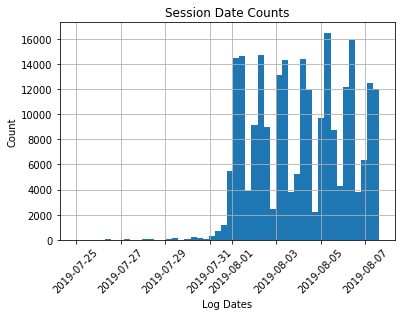

In [28]:
data['date_time'].hist(bins=50)
plt.xticks(rotation=45)
plt.title("Session Date Counts")
plt.ylabel("Count")
plt.xlabel("Log Dates")
plt.show()

# shows that after 7-31 there is a lot more data in the event logs

In [29]:
data['date'] = pd.to_datetime(data['date'])
new_data = data.loc[data['date'] > '2019-07-31']
new_data

,Event,DeviceId,EventTimestamp,ExpId,date_time,date,time
6189,MainScreenAppear,1389658498134948314,1564639203,248,2019-08-01 00:00:03,2019-08-01,00:00:03
6190,OffersScreenAppear,375723631317187672,1564639207,246,2019-08-01 00:00:07,2019-08-01,00:00:07
6191,MainScreenAppear,7375258168734936936,1564639207,248,2019-08-01 00:00:07,2019-08-01,00:00:07
6192,MainScreenAppear,6956382183518365612,1564639207,247,2019-08-01 00:00:07,2019-08-01,00:00:07
6193,MainScreenAppear,2180779893563165231,1564639212,247,2019-08-01 00:00:12,2019-08-01,00:00:12
...,...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 15:12:25,2019-08-07,15:12:25
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 15:13:59,2019-08-07,15:13:59
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 15:14:43,2019-08-07,15:14:43
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 15:14:58,2019-08-07,15:14:58


In [30]:
DeviceIdbyDateTotal = data.pivot_table(index='date', values='DeviceId', aggfunc='count' )
DeviceIdbyDateTotal.head(8)

#Lost 6189 rows of data

,DeviceId
date,
2019-07-24,1
2019-07-25,10
2019-07-26,30
2019-07-27,66
2019-07-28,101
2019-07-29,209
2019-07-30,445
2019-07-31,5320


In [31]:
NewDeviceIdbyDateTotal = new_data.pivot_table(index='date', values='DeviceId', aggfunc='count' )
NewDeviceIdbyDateTotal


,DeviceId
date,
2019-08-01,37598
2019-08-02,33531
2019-08-03,33260
2019-08-04,33603
2019-08-05,37089
2019-08-06,34977
2019-08-07,27473


In [32]:
date_counts = data.pivot_table(index='Event', values='DeviceId', aggfunc='count' )
date_counts.head(40)

,DeviceId
Event,
CartScreenAppear,42668
MainScreenAppear,119101
OffersScreenAppear,46808
PaymentScreenSuccessful,34118
Tutorial,1018


In [33]:
new_date_counts = new_data.pivot_table(index='Event', values='DeviceId', aggfunc='count' )
new_date_counts.head(40)

,DeviceId
Event,
CartScreenAppear,42054
MainScreenAppear,115161
OffersScreenAppear,45608
PaymentScreenSuccessful,33719
Tutorial,989


In [34]:
ExpIdCountOld = data.pivot_table(index='ExpId', values='DeviceId', aggfunc='count' )
ExpIdCountOld

,DeviceId
ExpId,
246,80181
247,77950
248,85582


In [35]:
ExpIdCountNew = new_data.pivot_table(index='ExpId', values='DeviceId', aggfunc='count' )
ExpIdCountNew

,DeviceId
ExpId,
246,78290
247,75802
248,83439


<div class="alert alert-info" role="alert">

#### Conclusion
* Original unfiltered data shows max and min dates and the data length covering two weeks. However, we saw that not all the data was relevant so we had to cut some out and decided it was better to start after 7-31.
- % OF old data is less than 1% as you can see so its okay. 
- We still have data on users from all expiremental groups.
- Evaluating the newer data we are able to see certain trends and behaviors better based off what screen they visit and other criteria like experiment groups. 

### Step 4

#### Study the event funnel
- See what events are in the logs and their frequency of occurrence. Sort them by frequency.
- Find the number of users who performed each of these actions. Sort the events by the number of users. Calculate the proportion of users who performed the action at least once.
- In what order do you think the actions took place. Are all of them part of a single sequence? You don't need to take them into account when calculating the funnel.
- Use the event funnel to find the share of users that proceed from each stage to the next. (For instance, for the sequence of events A → B → C, calculate the ratio of users at stage B to the number of users at stage A and the ratio of users at stage C to the number at stage B.)
- At what stage do you lose the most users?
- What share of users make the entire journey from their first event to payment?

In [36]:
data.head()

,Event,DeviceId,EventTimestamp,ExpId,date_time,date,time
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-24 22:43:36,2019-07-24,22:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 05:11:42,2019-07-25,05:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 05:28:47,2019-07-25,05:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 05:28:47,2019-07-25,05:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 05:48:42,2019-07-25,05:48:42


In [37]:
ExpIdbyDate = data.pivot_table(index='Event', values='DeviceId',aggfunc='nunique')
ExpIdbyDate.sort_values(by='DeviceId',ascending=False)

,DeviceId,Event
Event,,
MainScreenAppear,7439,1
OffersScreenAppear,4613,1
CartScreenAppear,3749,1
PaymentScreenSuccessful,3547,1
Tutorial,847,1


In [38]:
#EventsbyUsers=

In [39]:
dau_total = new_data.groupby('date').agg({'DeviceId': 'nunique'}).mean()
print('Average Daily Usage:', int(dau_total))

#wau_total = visits.groupby(['start_year', 'start_week']).agg({'Uid': 'nunique'}).mean()
#print('Average Monthly Usage:', int(mau_total))


Average Daily Usage: 3637


In [40]:
users = data.pivot_table(
    index='DeviceId', 
    columns='Event', 
    values='time',
    aggfunc='min')
users.head(25)

Event,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
DeviceId,,,,,
6888746892508752,NaN,08:06:34,NaN,NaN,NaN
6909561520679493,12:52:58,12:52:54,12:53:04,12:52:58,NaN
6922444491712477,00:33:15,00:33:11,00:33:21,00:33:15,NaN
7435777799948366,NaN,01:55:12,NaN,NaN,NaN
7702139951469979,01:25:27,00:15:36,00:15:40,01:25:27,NaN
8486814028069281,22:49:18,22:52:40,22:49:13,NaN,NaN
8740973466195562,NaN,03:16:48,03:43:59,NaN,NaN
9841258664663090,04:52:15,04:47:59,04:49:42,09:48:35,04:47:28
12692216027168046,NaN,08:38:50,08:38:32,NaN,NaN


based off the above pivot table looks like the offer screen appears at different times. It doesnt necessarily go in order. I assume the offers screen might be like an ad. 

In [41]:
step_1 = ~users['MainScreenAppear'].isna()
step_2 = step_1 & (users['OffersScreenAppear'] > users['MainScreenAppear'])
step_3 = step_2 & (users['CartScreenAppear'] > users['OffersScreenAppear'])
step_4 = step_3 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear'])
step_5 = step_4 & (users['CartScreenAppear'] > users['Tutorial'])

n_pageview = users[step_1].shape[0]
n_add_to_cart = users[step_2].shape[0]
n_checkout = users[step_3].shape[0]
n_payment = users[step_4].shape[0]
n_tutorial= users[step_5].shape[0]

n_pageview_conv = (n_pageview/(n_pageview+n_add_to_cart+n_checkout+n_payment+n_tutorial))
n_add_to_cart_conv = (n_add_to_cart/(n_pageview+n_add_to_cart+n_checkout+n_payment+n_tutorial))
n_checkout_conv = (n_checkout/(n_pageview+n_add_to_cart+n_checkout+n_payment+n_tutorial))
n_payment_conv = (n_payment/(n_pageview+n_add_to_cart+n_checkout+n_payment+n_tutorial))
n_tutorial_conv = (n_tutorial/(n_pageview+n_add_to_cart+n_checkout+n_payment+n_tutorial))



print('Visitors:', n_pageview, 'Conv%', n_pageview_conv)
print('Added a product to cart:', n_add_to_cart, 'Conv%', n_add_to_cart_conv)
print('Started checkout:', n_checkout, 'Conv%', n_checkout_conv)
print('Paid:', n_payment, 'Conv%', n_payment_conv)
print('Tutorial', n_tutorial, 'Conv%', n_tutorial_conv)



Visitors: 7439 Conv% 0.5415695981362842
Added a product to cart: 4059 Conv% 0.29550087361677346
Started checkout: 1720 Conv% 0.1252184041933605
Paid: 392 Conv% 0.028538147932440302
Tutorial 126 Conv% 0.009172976121141527


Not even 1% make the journey from the 1st event to payment. Looks like we lose most people after the Main Screen because we have the biggest difference between the Main and Offer Screen.

##### conclusion - ratio of users at the different stages from one to another as shown above
- Main Screen had 54% of users
- Offer Screen had 29% of users
- Check out process has 12% of users
- Payment Screen 2.8% of users
- Tutorial completion .09% of users

#### Conclusion

### Step 5

#### Study the results of the experiment
- How many users are there in each group? We have two control groups in the A/A test, where we check our mechanisms and calculations. See if there is a statistically significant difference between samples 246 and 247.
- Select the most popular event. In each of the control groups, find the number of users who performed this action. Find their share. Check whether the difference between the groups is statistically significant. Repeat the procedure for all other events (it will save time if you create a special function for this test). Can you confirm that the groups were split properly?
- Do the same thing for the group with altered fonts. Compare the results with those of each of the control groups for each event in isolation. Compare the results with the combined results for the control groups. What conclusions can you draw from the experiment?
- What significance level have you set to test the statistical hypotheses mentioned above? Calculate how many statistical hypothesis tests you carried out. With a statistical significance level of 0.1, one in 10 results could be false. What should the significance level be? If you want to change it, run through the previous steps again and check your conclusions.2

,ExpId,DeviceId
0,246,78290
1,247,75802
2,248,83439


Text(0.5, 0, 'Group')

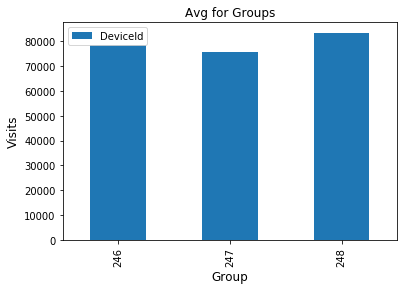

In [42]:
order_avg = new_data.drop(['date'], axis=1).groupby('ExpId', as_index=False).agg({'DeviceId' : 'count'})
display(order_avg)
barplot = order_avg.plot(x='ExpId', kind='bar')
plt.title('Avg for Groups')
plt.ylabel('Visits', fontsize=12)
plt.xlabel('Group', fontsize=12)

#### Hypothesis Test

- H0 (the null hypothesis): There's not a statistically significant difference in average order size between Group 246 and Group 247
- H1 (the alternative hypothesis): There's a statistically significant difference in average order size between Group 246 and Group 247
- alpha value = .05

In [43]:
#is there a statistically significant difference between control groups 246 and 247
import scipy.stats as stats
print("{0:.3f}".format(stats.mannwhitneyu(order_avg[order_avg['ExpId']==246]['DeviceId'], order_avg[order_avg['ExpId']==247]['DeviceId'])[1]))
print("{0:.3f}".format(order_avg[order_avg['ExpId']==247]['DeviceId'].mean()/order_avg[order_avg['ExpId']==246]['DeviceId'].mean()-1))
alpha = .05 #significance level
results2 = st.mannwhitneyu(order_avg[order_avg['ExpId']==246]['DeviceId'], order_avg[order_avg['ExpId']==247]['DeviceId'])
print('p-value: ', results2.pvalue)
if (results2.pvalue < alpha):
    print("H1 (the alternative hypothesis): there is a statistically significant difference in average order size between Group 246 and Group 247")
else:
    print("H0 (the null hypothesis): there's not a statistically significant difference in average order size between Group 246 and Group 247")

0.500
-0.032
p-value:  0.5
H0 (the null hypothesis): there's not a statistically significant difference in average order size between Group 246 and Group 247


In [44]:
pop_event = new_data.drop(['date'], axis=1).groupby('Event', as_index=False).agg({'DeviceId' : 'count'})
display(pop_event)

,Event,DeviceId
0,CartScreenAppear,42054
1,MainScreenAppear,115161
2,OffersScreenAppear,45608
3,PaymentScreenSuccessful,33719
4,Tutorial,989


In [45]:
#mainscreenappear
userswhoperformedmainscreen =  new_data.query('Event == "MainScreenAppear"')
userswhoperformedmainscreen

,Event,DeviceId,EventTimestamp,ExpId,date_time,date,time
6189,MainScreenAppear,1389658498134948314,1564639203,248,2019-08-01 00:00:03,2019-08-01,00:00:03
6191,MainScreenAppear,7375258168734936936,1564639207,248,2019-08-01 00:00:07,2019-08-01,00:00:07
6192,MainScreenAppear,6956382183518365612,1564639207,247,2019-08-01 00:00:07,2019-08-01,00:00:07
6193,MainScreenAppear,2180779893563165231,1564639212,247,2019-08-01 00:00:12,2019-08-01,00:00:12
6195,MainScreenAppear,8987628949126410882,1564639216,247,2019-08-01 00:00:16,2019-08-01,00:00:16
...,...,...,...,...,...,...,...
244120,MainScreenAppear,5746969938801999050,1565212331,246,2019-08-07 15:12:11,2019-08-07,15:12:11
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 15:12:25,2019-08-07,15:12:25
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 15:13:59,2019-08-07,15:13:59
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 15:14:43,2019-08-07,15:14:43


In [46]:
userswhoperformedmainscreen.pivot_table(index='ExpId',values='DeviceId',aggfunc='count').sort_values(by='DeviceId', ascending=True).reset_index()

,ExpId,DeviceId
0,246,37008
1,247,38356
2,248,39797


#### Hypothesis Test
- Check whether the difference between the groups is statistically significant for MainScreenAppear. 
- H0 (the null hypothesis): There's not a statistically significant difference in average order size between Group 246 and Group 247
- H1 (the alternative hypothesis): There's a statistically significant difference in average order size between Group 246 and Group 247
- alpha value = .05

In [47]:
print("{0:.3f}".format(stats.mannwhitneyu(userswhoperformedmainscreen[userswhoperformedmainscreen['ExpId']==246]['DeviceId'], userswhoperformedmainscreen[userswhoperformedmainscreen['ExpId']==247]['DeviceId'])[1]))
print("{0:.3f}".format(userswhoperformedmainscreen[userswhoperformedmainscreen['ExpId']==247]['DeviceId'].mean()/userswhoperformedmainscreen[userswhoperformedmainscreen['ExpId']==246]['DeviceId'].mean()-1)) 

alpha = .05 #significance level

results2 = st.mannwhitneyu(userswhoperformedmainscreen[userswhoperformedmainscreen['ExpId']==246]['DeviceId'], userswhoperformedmainscreen[userswhoperformedmainscreen['ExpId']==247]['DeviceId'])

print('p-value: ', results2.pvalue)

if (results2.pvalue < alpha):
    print("H1 (the alternative hypothesis): there is a statistically significant difference in average order size between Group 246 and Group 247")
else:
    print("H0 (the null hypothesis): there's not a statistically significant difference in average order size between Group 246 and Group 247")

0.000
0.019
p-value:  5.840494329666505e-06
H1 (the alternative hypothesis): there is a statistically significant difference in average order size between Group 246 and Group 247


In [48]:
#Repeat the procedure for all other events (it will save time if you create a special function for this test). 
#Can you confirm that the groups were split properly?

# event names
def data_by_event_name(EventName):
    """
    Labels users by number of days until first order.
    """
    if EventName == 'CartScreenAppear':
        return 'Cart'
    if EventName == 'MainScreenAppear':
        return 'Main'
    if EventName == 'OffersScreenAppear':
        return 'Offers'
    if EventName == 'PaymentScreenSuccessful':
        return 'Payment'
    else:
        return 'Tutorial'


new_data['days_to_order_group'] = new_data['Event'].apply(data_by_event_name)

event_data_pivot = new_data.pivot_table(index=['Event', 'ExpId'], columns='days_to_order_group', values='DeviceId', aggfunc='nunique', fill_value=0)
display(event_data_pivot)

days_to_order_group            Cart  Main  Offers  Payment  Tutorial
Event                   ExpId                                       
CartScreenAppear        246    1265     0       0        0         0
                        247    1235     0       0        0         0
                        248    1228     0       0        0         0
MainScreenAppear        246       0  2444       0        0         0
                        247       0  2472       0        0         0
                        248       0  2484       0        0         0
OffersScreenAppear      246       0     0    1536        0         0
                        247       0     0    1512        0         0
                        248       0     0    1528        0         0
PaymentScreenSuccessful 246       0     0       0     1198         0
                        247       0     0       0     1155         0
                        248       0     0       0     1179         0
Tutorial                246       0     0       0        0       274
                        247       0     0       0        0       276
                        248       0     0       0        0       276

In [49]:
#Check whether the difference between the groups is statistically significant 
CartScreenAppear =  new_data.query('Event == "CartScreenAppear"')
offersscreenappear =  new_data.query('Event == "OffersScreenAppear"') 
paymentsscreenappear =  new_data.query('Event == "PaymentScreenSuccessful"') 
tutoriascreenappear =  new_data.query('Event == "Tutorial"') 

### Testing 246 and 247

#### Hypothesis Test
- Check whether the difference between the groups is statistically significant for CartScreenAppear. 
- H0 (the null hypothesis): There's not a statistically significant difference in average order size between Group 246 and Group 247
- H1 (the alternative hypothesis): There's a statistically significant difference in average order size between Group 246 and Group 247
- alpha value = .05

In [50]:
#Check whether the difference between the groups is statistically significant for CartScreenAppear.  

print("{0:.3f}".format(stats.mannwhitneyu(CartScreenAppear[CartScreenAppear['ExpId']==246]['DeviceId'], CartScreenAppear[CartScreenAppear['ExpId']==247]['DeviceId'])[1]))
print("{0:.3f}".format(CartScreenAppear[CartScreenAppear['ExpId']==247]['DeviceId'].mean()/CartScreenAppear[CartScreenAppear['ExpId']==246]['DeviceId'].mean()-1)) 

alpha = .05 #significance level

results2 = st.mannwhitneyu(CartScreenAppear[CartScreenAppear['ExpId']==246]['DeviceId'], CartScreenAppear[CartScreenAppear['ExpId']==247]['DeviceId'])

print('p-value: ', results2.pvalue)

if (results2.pvalue < alpha):
    print("H1 (the alternative hypothesis): there is a statistically significant difference in average order size between Group 246 and Group 247")
else:
    print("H0 (the null hypothesis): there's not a statistically significant difference in average order size between Group 246 and Group 247")

0.000
0.033
p-value:  1.8520807916741869e-06
H1 (the alternative hypothesis): there is a statistically significant difference in average order size between Group 246 and Group 247


#### Hypothesis Test
- Check whether the difference between the groups is statistically significant for OffersScreenAppear.
- H0 (the null hypothesis): There's not a statistically significant difference in average order size between Group 246 and Group 247
- H1 (the alternative hypothesis): There's a statistically significant difference in average order size between Group 246 and Group 247
- alpha value = .05

In [51]:
#Check whether the difference between the groups is statistically significant for OffersScreenAppear.

print("{0:.3f}".format(stats.mannwhitneyu(offersscreenappear[offersscreenappear['ExpId']==246]['DeviceId'], offersscreenappear[offersscreenappear['ExpId']==247]['DeviceId'])[1]))
print("{0:.3f}".format(offersscreenappear[offersscreenappear['ExpId']==247]['DeviceId'].mean()/offersscreenappear[offersscreenappear['ExpId']==246]['DeviceId'].mean()-1)) 

alpha = .05 #significance level

results2 = st.mannwhitneyu(offersscreenappear[offersscreenappear['ExpId']==246]['DeviceId'], offersscreenappear[offersscreenappear['ExpId']==247]['DeviceId'])

print('p-value: ', results2.pvalue)

if (results2.pvalue < alpha):
    print("H1 (the alternative hypothesis): there is a statistically significant difference in average order size between Group 246 and Group 247")
else:
    print("H0 (the null hypothesis): there's not a statistically significant difference in average order size between Group 246 and Group 247")

0.000
0.063
p-value:  2.389673162139441e-19
H1 (the alternative hypothesis): there is a statistically significant difference in average order size between Group 246 and Group 247


#### Hypothesis Test
- Check whether the difference between the groups is statistically significant for PaymentScreenSuccessful.
- H0 (the null hypothesis): There's not a statistically significant difference in average order size between Group 246 and Group 247
- H1 (the alternative hypothesis): There's a statistically significant difference in average order size between Group 246 and Group 247
- alpha value = .05

In [52]:
#Check whether the difference between the groups is statistically significant for PaymentScreenSuccessful.

print("{0:.3f}".format(stats.mannwhitneyu(paymentsscreenappear[paymentsscreenappear['ExpId']==246]['DeviceId'], paymentsscreenappear[paymentsscreenappear['ExpId']==247]['DeviceId'])[1]))
print("{0:.3f}".format(paymentsscreenappear[paymentsscreenappear['ExpId']==247]['DeviceId'].mean()/paymentsscreenappear[paymentsscreenappear['ExpId']==246]['DeviceId'].mean()-1)) 

alpha = .05 #significance level

results2 = st.mannwhitneyu(paymentsscreenappear[paymentsscreenappear['ExpId']==246]['DeviceId'], paymentsscreenappear[paymentsscreenappear['ExpId']==247]['DeviceId'])

print('p-value: ', results2.pvalue)

if (results2.pvalue < alpha):
    print("H1 (the alternative hypothesis): there is a statistically significant difference in average order size between Group 246 and Group 247")
else:
    print("H0 (the null hypothesis): there's not a statistically significant difference in average order size between Group 246 and Group 247")

0.001
0.024
p-value:  0.0012769232943949378
H1 (the alternative hypothesis): there is a statistically significant difference in average order size between Group 246 and Group 247


#### Hypothesis Test
- Check whether the difference between the groups is statistically significant for Tutorial.
- H0 (the null hypothesis): There's not a statistically significant difference in average order size between Group 246 and Group 247
- H1 (the alternative hypothesis): There's a statistically significant difference in average order size between Group 246 and Group 247
- alpha value = .05

In [53]:
#Check whether the difference between the groups is statistically significant for Tutorial.

print("{0:.3f}".format(stats.mannwhitneyu(tutoriascreenappear[tutoriascreenappear['ExpId']==246]['DeviceId'], tutoriascreenappear[tutoriascreenappear['ExpId']==247]['DeviceId'])[1]))
print("{0:.3f}".format(tutoriascreenappear[tutoriascreenappear['ExpId']==247]['DeviceId'].mean()/tutoriascreenappear[tutoriascreenappear['ExpId']==246]['DeviceId'].mean()-1)) 

alpha = .05 #significance level

results2 = st.mannwhitneyu(tutoriascreenappear[tutoriascreenappear['ExpId']==246]['DeviceId'], tutoriascreenappear[tutoriascreenappear['ExpId']==247]['DeviceId'])

print('p-value: ', results2.pvalue)

if (results2.pvalue < alpha):
    print("H1 (the alternative hypothesis): there is a statistically significant difference in average order size between Group 246 and Group 247")
else:
    print("H0 (the null hypothesis): there's not a statistically significant difference in average order size between Group 246 and Group 247")

0.445
0.007
p-value:  0.44484769196118124
H0 (the null hypothesis): there's not a statistically significant difference in average order size between Group 246 and Group 247


### Testing 246 and 248:

#### Hypothesis Test
- Check whether the difference between the groups is statistically significant for Tutorial.
- H0 (the null hypothesis): There's not a statistically significant difference in average order size between Group 246 and Group 248
- H1 (the alternative hypothesis): There's a statistically significant difference in average order size between Group 246 and Group 248
- alpha value = .05

In [54]:
#Do the same thing for the group with altered fonts. 
#Check whether the difference between the groups is statistically significant for Tutorial.

print("{0:.3f}".format(stats.mannwhitneyu(tutoriascreenappear[tutoriascreenappear['ExpId']==246]['DeviceId'], tutoriascreenappear[tutoriascreenappear['ExpId']==248]['DeviceId'])[1]))
print("{0:.3f}".format(tutoriascreenappear[tutoriascreenappear['ExpId']==248]['DeviceId'].mean()/tutoriascreenappear[tutoriascreenappear['ExpId']==246]['DeviceId'].mean()-1)) 

alpha = .05 #significance level

results2 = st.mannwhitneyu(tutoriascreenappear[tutoriascreenappear['ExpId']==246]['DeviceId'], tutoriascreenappear[tutoriascreenappear['ExpId']==248]['DeviceId'])

print('p-value: ', results2.pvalue)

if (results2.pvalue < alpha):
    print("H1 (the alternative hypothesis): there is a statistically significant difference in average order size between Group 246 and Group 248")
else:
    print("H0 (the null hypothesis): there's not a statistically significant difference in average order size between Group 246 and Group 248")


0.308
0.021
p-value:  0.3082291197195416
H0 (the null hypothesis): there's not a statistically significant difference in average order size between Group 246 and Group 248


#### Hypothesis Test
- Check whether the difference between the groups is statistically significant for CartScreenAppear.
- H0 (the null hypothesis): There's not a statistically significant difference in average order size between Group 246 and Group 247
- H1 (the alternative hypothesis): There's a statistically significant difference in average order size between Group 246 and Group 247
- alpha value = .05

In [55]:
#Check whether the difference between the groups is statistically significant for CartScreenAppear.  

print("{0:.3f}".format(stats.mannwhitneyu(CartScreenAppear[CartScreenAppear['ExpId']==246]['DeviceId'], CartScreenAppear[CartScreenAppear['ExpId']==247]['DeviceId'])[1]))
print("{0:.3f}".format(CartScreenAppear[CartScreenAppear['ExpId']==248]['DeviceId'].mean()/CartScreenAppear[CartScreenAppear['ExpId']==246]['DeviceId'].mean()-1)) 

alpha = .05 #significance level

results2 = st.mannwhitneyu(CartScreenAppear[CartScreenAppear['ExpId']==246]['DeviceId'], CartScreenAppear[CartScreenAppear['ExpId']==248]['DeviceId'])

print('p-value: ', results2.pvalue)

if (results2.pvalue < alpha):
    print("H1 (the alternative hypothesis): there is a statistically significant difference in average order size between Group 246 and Group 248")
else:
    print("H0 (the null hypothesis): there's not a statistically significant difference in average order size between Group 246 and Group 248")

0.000
0.042
p-value:  8.00866163737927e-09
H1 (the alternative hypothesis): there is a statistically significant difference in average order size between Group 246 and Group 248


#### Hypothesis Test
- Check whether the difference between the groups is statistically significant for PaymentScreenSuccessful.
- H0 (the null hypothesis): There's not a statistically significant difference in average order size between Group 246 and Group 248
- H1 (the alternative hypothesis): There's a statistically significant difference in average order size between Group 246 and Group 248
- alpha value = .05

In [56]:
#Do the same thing for the group with altered fonts. 
#Check whether the difference between the groups is statistically significant for PaymentScreenSuccessful.

print("{0:.3f}".format(stats.mannwhitneyu(paymentsscreenappear[paymentsscreenappear['ExpId']==246]['DeviceId'], paymentsscreenappear[paymentsscreenappear['ExpId']==248]['DeviceId'])[1]))
print("{0:.3f}".format(paymentsscreenappear[paymentsscreenappear['ExpId']==248]['DeviceId'].mean()/paymentsscreenappear[paymentsscreenappear['ExpId']==246]['DeviceId'].mean()-1)) 

alpha = .05 #significance level

results2 = st.mannwhitneyu(paymentsscreenappear[paymentsscreenappear['ExpId']==246]['DeviceId'], paymentsscreenappear[paymentsscreenappear['ExpId']==248]['DeviceId'])

print('p-value: ', results2.pvalue)

if (results2.pvalue < alpha):
    print("H1 (the alternative hypothesis): there is a statistically significant difference in average order size between Group 246 and Group 248")
else:
    print("H0 (the null hypothesis): there's not a statistically significant difference in average order size between Group 246 and Group 248")

0.000
0.043
p-value:  6.809338498416768e-07
H1 (the alternative hypothesis): there is a statistically significant difference in average order size between Group 246 and Group 248


#### Hypothesis Test
- Check whether the difference between the groups is statistically significant for OffersScreenAppear.
- H0 (the null hypothesis): There's not a statistically significant difference in average order size between Group 246 and Group 248
- H1 (the alternative hypothesis): There's a statistically significant difference in average order size between Group 246 and Group 248
- alpha value = .05

In [57]:
#Do the same thing for the group with altered fonts. 
#Check whether the difference between the groups is statistically significant for OffersScreenAppear.

print("{0:.3f}".format(stats.mannwhitneyu(offersscreenappear[offersscreenappear['ExpId']==246]['DeviceId'], offersscreenappear[offersscreenappear['ExpId']==248]['DeviceId'])[1]))
print("{0:.3f}".format(offersscreenappear[offersscreenappear['ExpId']==248]['DeviceId'].mean()/offersscreenappear[offersscreenappear['ExpId']==246]['DeviceId'].mean()-1)) 

alpha = .05 #significance level

results2 = st.mannwhitneyu(offersscreenappear[offersscreenappear['ExpId']==246]['DeviceId'], offersscreenappear[offersscreenappear['ExpId']==248]['DeviceId'])

print('p-value: ', results2.pvalue)

if (results2.pvalue < alpha):
    print("H1 (the alternative hypothesis): there is a statistically significant difference in average order size between Group 246 and Group 248")
else:
    print("H0 (the null hypothesis): there's not a statistically significant difference in average order size between Group 246 and Group 248")

0.000
0.063
p-value:  3.754184096736272e-20
H1 (the alternative hypothesis): there is a statistically significant difference in average order size between Group 246 and Group 248


### Testing 247 and 248:

#### Hypothesis Test
- Check whether the difference between the groups is statistically significant for CartScreenAppear.
- H0 (the null hypothesis): There's not a statistically significant difference in average order size between Group 247 and Group 248
- H1 (the alternative hypothesis): There's a statistically significant difference in average order size between Group 247 and Group 248
- alpha value = .05

In [58]:
#Check whether the difference between the groups is statistically significant for CartScreenAppear.  

print("{0:.3f}".format(stats.mannwhitneyu(CartScreenAppear[CartScreenAppear['ExpId']==247]['DeviceId'], CartScreenAppear[CartScreenAppear['ExpId']==248]['DeviceId'])[1]))
print("{0:.3f}".format(CartScreenAppear[CartScreenAppear['ExpId']==247]['DeviceId'].mean()/CartScreenAppear[CartScreenAppear['ExpId']==248]['DeviceId'].mean()-1)) 

alpha = .05 #significance level

results2 = st.mannwhitneyu(CartScreenAppear[CartScreenAppear['ExpId']==247]['DeviceId'], CartScreenAppear[CartScreenAppear['ExpId']==248]['DeviceId'])

print('p-value: ', results2.pvalue)

if (results2.pvalue < alpha):
    print("H1 (the alternative hypothesis): there is a statistically significant difference in average order size between Group 247 and Group 248")
else:
    print("H0 (the null hypothesis): there's not a statistically significant difference in average order size between Group 247 and Group 248")

0.028
-0.009
p-value:  0.02831724085727264
H1 (the alternative hypothesis): there is a statistically significant difference in average order size between Group 247 and Group 248


#### Hypothesis Test
- Check whether the difference between the groups is statistically significant for MainScreen.
- H0 (the null hypothesis): There's not a statistically significant difference in average order size between Group 247 and Group 248
- H1 (the alternative hypothesis): There's a statistically significant difference in average order size between Group 247 and Group 248
- alpha value = .05

In [59]:
#Do the same thing for the group with altered fonts. 
#Check whether the difference between the groups is statistically significant for MainScreenAppear. 

print("{0:.3f}".format(stats.mannwhitneyu(userswhoperformedmainscreen[userswhoperformedmainscreen['ExpId']==247]['DeviceId'], userswhoperformedmainscreen[userswhoperformedmainscreen['ExpId']==248]['DeviceId'])[1]))
print("{0:.3f}".format(userswhoperformedmainscreen[userswhoperformedmainscreen['ExpId']==247]['DeviceId'].mean()/userswhoperformedmainscreen[userswhoperformedmainscreen['ExpId']==248]['DeviceId'].mean()-1)) 

alpha = .05 #significance level

results2 = st.mannwhitneyu(userswhoperformedmainscreen[userswhoperformedmainscreen['ExpId']==247]['DeviceId'], userswhoperformedmainscreen[userswhoperformedmainscreen['ExpId']==248]['DeviceId'])

print('p-value: ', results2.pvalue)

if (results2.pvalue < alpha):
    print("H1 (the alternative hypothesis): there is a statistically significant difference in average order size between Group 247 and Group 248")
else:
    print("H0 (the null hypothesis): there's not a statistically significant difference in average order size between Group 247 and Group 248")

0.000
0.022
p-value:  3.250694006460116e-08
H1 (the alternative hypothesis): there is a statistically significant difference in average order size between Group 247 and Group 248


#### Hypothesis Test
- Check whether the difference between the groups is statistically significant for OfferScreen.
- H0 (the null hypothesis): There's not a statistically significant difference in average order size between Group 247 and Group 248
- H1 (the alternative hypothesis): There's a statistically significant difference in average order size between Group 247 and Group 248
- alpha value = .05

In [60]:
#Check whether the difference between the groups is statistically significant for OffersScreenAppear.

print("{0:.3f}".format(stats.mannwhitneyu(offersscreenappear[offersscreenappear['ExpId']==247]['DeviceId'], offersscreenappear[offersscreenappear['ExpId']==248]['DeviceId'])[1]))
print("{0:.3f}".format(offersscreenappear[offersscreenappear['ExpId']==247]['DeviceId'].mean()/offersscreenappear[offersscreenappear['ExpId']==248]['DeviceId'].mean()-1)) 

alpha = .05 #significance level

results2 = st.mannwhitneyu(offersscreenappear[offersscreenappear['ExpId']==247]['DeviceId'], offersscreenappear[offersscreenappear['ExpId']==248]['DeviceId'])

print('p-value: ', results2.pvalue)

if (results2.pvalue < alpha):
    print("H1 (the alternative hypothesis): there is a statistically significant difference in average order size between Group 247 and Group 248")
else:
    print("H0 (the null hypothesis): there's not a statistically significant difference in average order size between Group 247 and Group 248")

0.469
0.000
p-value:  0.46861302053730847
H0 (the null hypothesis): there's not a statistically significant difference in average order size between Group 247 and Group 248


#### Hypothesis Test
- Check whether the difference between the groups is statistically significant for Payment Screen.
- H0 (the null hypothesis): There's not a statistically significant difference in average order size between Group 247 and Group 248
- H1 (the alternative hypothesis): There's a statistically significant difference in average order size between Group 247 and Group 248
- alpha value = .05

In [61]:
#Do the same thing for the group with altered fonts. 
#Check whether the difference between the groups is statistically significant for PaymentScreenSuccessful.

print("{0:.3f}".format(stats.mannwhitneyu(paymentsscreenappear[paymentsscreenappear['ExpId']==247]['DeviceId'], paymentsscreenappear[paymentsscreenappear['ExpId']==248]['DeviceId'])[1]))
print("{0:.3f}".format(paymentsscreenappear[paymentsscreenappear['ExpId']==247]['DeviceId'].mean()/paymentsscreenappear[paymentsscreenappear['ExpId']==248]['DeviceId'].mean()-1)) 

alpha = .05 #significance level

results2 = st.mannwhitneyu(paymentsscreenappear[paymentsscreenappear['ExpId']==247]['DeviceId'], paymentsscreenappear[paymentsscreenappear['ExpId']==248]['DeviceId'])

print('p-value: ', results2.pvalue)

if (results2.pvalue < alpha):
    print("H1 (the alternative hypothesis): there is a statistically significant difference in average order size between Group 247 and Group 248")
else:
    print("H0 (the null hypothesis): there's not a statistically significant difference in average order size between Group 247 and Group 248")

0.001
-0.018
p-value:  0.0006502117276731798
H1 (the alternative hypothesis): there is a statistically significant difference in average order size between Group 247 and Group 248


#### Hypothesis Test
- Check whether the difference between the groups is statistically significant for Tutorial.
- H0 (the null hypothesis): There's not a statistically significant difference in average order size between Group 247 and Group 248
- H1 (the alternative hypothesis): There's a statistically significant difference in average order size between Group 247 and Group 248
- alpha value = .05

In [62]:
#Do the same thing for the group with altered fonts. 
#Check whether the difference between the groups is statistically significant for Tutorial.

print("{0:.3f}".format(stats.mannwhitneyu(tutoriascreenappear[tutoriascreenappear['ExpId']==247]['DeviceId'], tutoriascreenappear[tutoriascreenappear['ExpId']==248]['DeviceId'])[1]))
print("{0:.3f}".format(tutoriascreenappear[tutoriascreenappear['ExpId']==247]['DeviceId'].mean()/tutoriascreenappear[tutoriascreenappear['ExpId']==247]['DeviceId'].mean()-1)) 

alpha = .05 #significance level

results2 = st.mannwhitneyu(tutoriascreenappear[tutoriascreenappear['ExpId']==247]['DeviceId'], tutoriascreenappear[tutoriascreenappear['ExpId']==248]['DeviceId'])

print('p-value: ', results2.pvalue)

if (results2.pvalue < alpha):
    print("H1 (the alternative hypothesis): there is a statistically significant difference in average order size between Group 247 and Group 248")
else:
    print("H0 (the null hypothesis): there's not a statistically significant difference in average order size between Group 247 and Group 248")

0.347
0.000
p-value:  0.34703750211138706
H0 (the null hypothesis): there's not a statistically significant difference in average order size between Group 247 and Group 248


##### What conclusions can you draw from the experiment?

When conducting the AA test agains 246 and 247 we found that there were statistical significances for payment, offers cart and main screens

When conducting the AA test against 247 and 248 we found that there were statistidal significances for payment, cart and main screens

when conducting the AA test against 246 and 248 we found that there were statstical significances for payment, offers and cart screens 

Stat significance level was .5 because its generally used and indicative of strong evidence against the null hypothesis, because of the probability being less than 5% null is correct, making it appropriate. It points out that main screen and offer screen are motivators for behavior of users.

carried out 16 hypothesis tests

### Project Conclusion

#### Data uncovered
- When we started assessing the population of this experiment, we were able to determine that there were 2437130 events in the logs that included dates from 07/25-08/07/2019.
- The average number of users in the logs were 7551. 
- The users that were accessing the site before 07/31 might have experienced technical issues, prior marketing campaigns or simply because the product we were offering did not capture the users interest. 
- Average events per user were around 32 before we started evaluating the date ranges after 07/31/2019.
- We were able to create a table that demonstrated the average period users were accessing the data was between 07/31-08/07/2019. So, we created a funnel to eliminate the data that wasn’t pertaining to our experiment. We decided to remove the users outside of this date range because it was .01% of the total users. 
- When we funneled out the data, we realized that the test group 248 comprised most of the users accessing the data. 246 was second greatest number of users followed by 247.
- We can see that when we investigate the funnel of new users we see the breakdown below that shows share of users who proceed from one stage to another:

    Main Screen had 54% of users, Offer Screen had 29% of users,Check out process has 12% of users,Payment Screen 2.8% of users,Tutorial completion .09% of users
    
#### Test Groups
- Out of these test groups we saw that the highest number of users were accessing the main screen but did not proceed through to payment. This might have been because the offers were not enticing enough to pursue the purchase, or because people forget or change their mind as money do when shopping, etc. (This is where we had to evaluate the statistical significance of each group by performing Mann Whitney tests.)
- When conducting the AA test against 246 and 247 we found that there were statistical significances for payment, offers cart and main screens.
- When conducting the AA test against 247 and 248 we found that there were statistical significances for payment, cart and main screens.
- when conducting the AA test against 246 and 248 we found that there were statistical significances for payment, offers and cart screens.

#### Suggestion 
- With this data in mind, it would be wise for the marketing team to entice users with font changes in payment screen and Cart screen. Changing the fonts in the offers screen and the main screen didn't make much difference. We can base this off the amount of time the users visit the site and add items to the cart but never go back to purchase. Changing the fonts in the cart screen and the payment screen and enticing users with offers when items are in the cart, but not purchased immediately might be a good marketing tactic to gain business.  